## 6.832: Problem Set #5 -  Part 2 of 2

Due on Friday, May 3, 2019 at 23:59.  See course website for submission details. Use Drake release tag `drake-20190423`, i.e. use this notebook via `./docker_run_notebook.sh drake-20190423 .`, or whichever script you need for your platform.

May the 4th be with you!

## Dynamic control for manipulation

In the previous section, you developed a tool for analyzing whether a given grasp of an object is likely to be stable or not. In this section, we'll develop a tool for controlling the robot and object after that grasp has been achieved. Where the previous section used a simplified model that largely ignored the details of the robot, we'll embrace the object and robot dynamics here to write a simple but powerful controller to manipulate the object in the robot's hand!

## The controller

### Assumptions

We're going to write a controller for a fully-actuated, fixed-base robot hand that has grabbed an unactuated rigid object (the "manipuland"). Note that taken together, the robot+object can be considered an underactuated system. The whole system is pictured below, and constructed in the *BuildHand* function in *planar_hand.py*.

<p align="center">
  <img src="hand_diagram.png" width="350"/>
</p>

To be specific, for every finger, you have direct torque control of each joint (including the base joint) of the finger. (That is, everything rendered in red.) There are no joint limits, and all motion takes place in the XY plane (so there is no gravity). You'll have a perfect estimate of the robot and manipuland state.

Our controller will assume that the robot has exactly achieved the desired grasp (that is, a fingertip is in contact with the object at each of a set of positions on the object), and that it'll maintain that grasp for the rest of time. It also assumes no other contacts exist. A natural extension of this controller would be to include an estimator of the contact state and contact locations -- and to react accordingly by planning to achieve contact, and planning regrasps when necessary -- but let's start simple!

## Problem statement

The core objectives are to:

1) **Control the hand and manipuland to follow a desired trajectory through space.**

2) **Regulate the contact normal forces with the manipuland.**

## Approach

An ideal approach for this problem would be to perform a trajectory optimization far into the future at every time step, starting from the current state, and optimize your control actions to cause the object to move as desired and achieve the desired contact forces. That's usually intractable, though -- but what if you only simulated a *single* step forward in time? We'll construct a quadratic (convex) optimization that searches over feasible inputs, accelerations, and contact forces to achieve our above objectives. This is exactly the kind of control we use to, for example, [drive Atlas](http://groups.csail.mit.edu/robotics-center/public_papers/Kuindersma13.pdf) -- it works very well!

### Instantaneous dynamics

In this case, if you assume your instantaneous dynamics will be valid until your next control tick, your dynamics become linear! You can see that from the manipulator equations. In the case with contact, our robot has dynamics

$$
M(q) \ddot{q} + C(q, \dot{q}) v = Bu + \Phi(q)^T \lambda
$$

following [C.3.1 in the textbook](http://underactuated.csail.mit.edu/underactuated.html?chapter=multibody). For a vector of contact forces (in world frame) $\lambda$, they affect the system dynamics by operating through the contact Jacobian $\Phi$, which is itself a function of the robot state. Instantaneously, $q$ and $v$ are known and constant, so $\ddot{q}$, $\lambda$, and $u$ enter linearly.

*($\Phi$ is described in some detail in the textbook, but the core idea is that it maps contact forces in generalized (world) coordinates into the joint coordinates of the robot. In our case of forces occuring from point contacts, then you can think about $\Phi$ as describing how movement of the contact point is reflected in the joint coordinates of the robot. Check out the code for how we calculate it in this case!)*

### Modeling feasible contacts

The second piece of this puzzle is that not all contact forces are feasible: assuming a fixed set of non-sliding contacts means the contact forces must only push on the manipuland, and they must also obey coulomb friction. These are exactly the friction cone constraints from the previous section -- though because our contact forces will be expressed in world frame, we'll describe the (instantaneous) friction cone in world frame as well.

Take $\lambda$ to be a stack of world-frame contact forces $\left[\lambda_1, ..., \lambda_n\right]$ for individual planar contact forces $\lambda_i = \left[\lambda_{i,x}, \lambda_{i,y}\right]$. At a given instant, $\lambda_i$ must live inside a cone positively spanned by vectors $c_{i, 0}$ and $c_{i, 2}$: 

$$\lambda_i = c_{i, 1} * \beta_{i, 1} + c_{i, 2} * \beta_{i, 2} \ \ \ \beta_{i, 0}, \beta_{i, 1} \geq 0$$

where the vectors $c_{i, j}$ are calculated in world frame using the contact normal and tangent vectors at the $i^{th}$ grasp point, which are transformed depending on the pose and shape of the manipuland.

<p align="center">
  <img src="friction_cone_world_frame.png" width="400"/>
</p>

### Objective function

The above constraints allow you to represent the dynamics of this robot in its given contact configuration linearly. So if you construct a quadratic objective, you'll stay within the efficiently-solvable world of quadratic programs!

As noted in class, there's a lot of room for freedom in designing the objective here. Since you have direct access to $\ddot{q}$, $\lambda$, and the other decision variables, achieving goals (1) and (2) from the problem statement should be fairly direct.

*(Where do the supplied hand postures come from? Good question! Included in this set is an example of solving an inverse kinematics problem (as a nonlinear optimization) to find a posture for the robot that achieves the desired contact locations given the current object location while remaining close to a reasonable "nominal" posture. It works in real time for this small system, but might be hard to scale. What we're writing here is more of a controller than a planner -- often roboticists will generate a trajectory of desired postures ahead of time using a non-real-time trajectory optimization, and then use a controller like this one to stabilize it in real time.)*

### Full formulation

This leads us to a full formulation for single-step dynamics-aware control given this contact situation.

$$
\begin{align}
&\min_{\ddot{q}, \lambda, u, \beta} Q(q, \dot{q}, \ddot{q}, \lambda, u) \\
s.t. \ & M \ddot{q} + C = Bu +\Phi^T \lambda \\
& \lambda_i = c_{i, 0} \beta_{i, 0} + c_{i, 1} \beta_{i, 1} \ \ \ \forall i \\
& \beta_{i, j} \geq 0 \ \ \ \forall i, j
\end{align}
$$

where $q$ and $\dot{q}$ are supplied and constant, and $M$, $C$, $\Phi$, and the friction cone basis vectors $c_{i, j}$ are evaluated (and so also constant) at that configuration, for a quadratic objective $Q$ that you'll design.

## YOUR MISSION

The file `planar_hand.py` includes everything you need to set up and simulate this system, and this notebook provides examples below for simulating the complete system. It assumes that you've completed the grasp evaluation methods from the other notebook, so go do those first if you haven't.

**Implement the above controller in the `ComputeControlInput` method of the `HandController` class.** Feel free to peruse the rest of the controller to understand what it's doing -- at a high level, the major methods are described below.

To clarify -- you ONLY need to implement the remaining portion of `ComputeControlInput` -- nothing else!  Also the first half of this function has been implemented for you.

If you're feeling lost, the precise order in which we recommend you proceed is:

1) Start out ignoring contacts, and write a Q that only worries about controlling $q^{hand}$ to $q^{hand}_{des}$. The whole optimization should look something like
$$
\begin{align}
&\min_{\ddot{q}, u} K_p ||q^{hand}_{des} - q^{hand}||^2 + K_d ||\dot{q}^{hand}_{des} - \dot{q}^{hand}||^2 \\
s.t. \ & M \ddot{q} + C = Bu \\
\end{align}
$$
where $K_p$ and $K_d$ are PD control gains for regulating the arm posture. This should control the hand to achieve the contact points (while accounting for the dynamics of the arm), and as a consequence move the object around (though not very well).

2) Then worry about writing the complete optimization written above (that also searches over contact forces that obey friction cone constraints), with additional terms in the objective to regulate the object position. (Feel free to experiment with other things, too -- like encouraging contact force to be large, weighting different joints of the hand differently, etc. But these aren't strictly necessary to complete the set.)

### Specs

The tests will spawn the system with between 2 and 4 fingers and several simple manipuland trajectories. The exact `manipuland_trajectory_callback` functions it'll use are copied below, for your reference. For each of these, it will check:

1) That the final posture of the manipuland was within 0.25 of the desired goal pose in all dimensions. 

2) That the average contact force (across all contacts that happened) during the last 1 second of a 10 second simulation was always above 0.1. (i.e., a reasonable grip was maintained).

### Guide the the rest of the code

1) `PlanGraspPoints`, which extracts the geometry of the manipuland and randomly samples sets of grasp points on its surface, picking the best one by using your metrics to check if it is force closure and ranking the force closure grasps by their volume. (It also double-checks that the grasps are reachable by the robot by doing a ComputeTargetPosture call, and uses a neat LP to decide which finger will grab which grasp point.)

2) `GetDesiredObjectPosition`, which dispatches to a `manipuland_trajectory_callback` to provide manipuland pose goals given a time. These are the manipuland pose goals the controller will try to track.

3) `ComputeTargetPosture`, which computes a posture for the hand that puts the fingertips where they should be to hold the object at a specified pose, while keeping the hand close to a specified nominal posture. It assumes `PlanGraspPoints` has already been called so it can use the grasp points that were chosen. It uses Drake's inverse kinematic helper class (which helps set up a nonlinear optimization to optimize over robot postures) -- a very powerful class that might be useful in your final projects! We use it nonstop on all of our robots -- for example, to [get Atlas into the car](https://www.youtube.com/watch?v=m1rv4d_zUCY).

In [22]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import planar_hand

# You can change this number to change
# the number of fingers added to the
# hand. More than 5 gets hard.
num_fingers = 2
# There are 3 joints per finger, so
# the number of positions for the whole hand is...
num_hand_q = num_fingers * 3

# Feel free to tweak, but this pose works
# reasoanbly well given this hand size.
initial_manipuland_pose = np.array([1.5, 0., 0.])

# Change this callback to change the nominal
# trajectory for the manipuland through space.
# The default example moves the object from 
# [1, 0, 0] to [1, 0.5, 0.5].
# Make sure the initial pose matches your initial
# manipuland pose, defined above.
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
def manipuland_trajectory_callback_custom(t):
    ''' Must return a 3x1 numpy array of floats, indicating
        the desired manipuland pose (x y theta) at time t.'''
    return np.array([1.5 + 0.5 * math.sin(t/2.), 0.5 * math.sin(t/3.), 0.0])

# The callbacks used for testing, for your convenience.
def test_manipuland_trajectory_callback_A(t):
    return np.array([1.5, 0.5 * sigmoid(t - 2.5), 0.5 * sigmoid(t - 2.5)])
def test_manipuland_trajectory_callback_B(t):
    return np.array([1.5, -0.5 * sigmoid(t - 2.5), 0.5 * sigmoid(t - 2.5)])
def test_manipuland_trajectory_callback_C(t):
    return np.array([1.5 - 0.5 * sigmoid(t - 2.5), 0.5, 0.0])

# Run the simulation. Parameters not described above
# are:
#   - The duration of simulation (in seconds)
#   - # of random grasp point sets to use when searching
#     for a grasp of the object.
#   - The period of the controller update (your QP is called at this rate)
#   - The coefficient of friction assumed by the controller. Does not
#     affect the simulator (whose friction is fixed to 0.9). A conservative
#     value of 0.5 works pretty well.
#   - The manipuland sdf. Options included in this set are:
#       "models/manipuland_ball.sdf"
#       "models/manipuland_ball_large.sdf"
#       "models/manipuland_box.sdf"
#       "models/manipuland_irregular_blob.sdf"
#       "models/manipuland_triangle.sdf"
hand, plant, controller, state_log, contact_log = \
    planar_hand.SimulateHand(
        num_fingers=num_fingers,
        manipuland_sdf="models/manipuland_box.sdf",
        mu=0.5,
        initial_manipuland_pose=initial_manipuland_pose,
        manipuland_trajectory_callback = test_manipuland_trajectory_callback_C,
        duration=10,
        n_grasp_search_iters=100,
        control_period = 0.0333)

print "Done!"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
t:  0.0
t:  1.0015
t:  2.003
t:  3.0045
t:  4.006
t:  5.0075
t:  6.009
t:  7.0105
t:  8.012
t:  9.0135
Done!


In [24]:
# Visualize the simulation as a video
import matplotlib.pyplot as plt
from underactuated import PlanarRigidBodyVisualizer
from IPython.display import HTML

fig, ax = plt.subplots(1)
fig.set_size_inches(6, 6)
# This custom Tview creates a top-down view.
# (It functions as a projection matrix -- 3D poses are
# multiplied by it to produce their position in the view
# window.)
viz = PlanarRigidBodyVisualizer(hand, xlim=[-2, 4], ylim=[-3, 3],
                   Tview=np.array([[1., 0., 0., 0.],
                                   [0., 1., 0., 0.],
                                   [0., 0., 0., 1.]]),
                   #fig=fig,
                   ax=ax)
# This extra visualizer overlays the contact forces.
hand_viz = planar_hand.PlanarHandExtrasVisualizer(controller,
                                                  plant,
                                                  viz,
                                                  fig=fig,
                                                  ax=ax,
                                                  show_forces=True)
ani = hand_viz.animate(state_log, contact_log, 0.0333, repeat=True)
plt.close(fig)
# This needs to be the last line for the video to display
HTML(ani.to_html5_video())

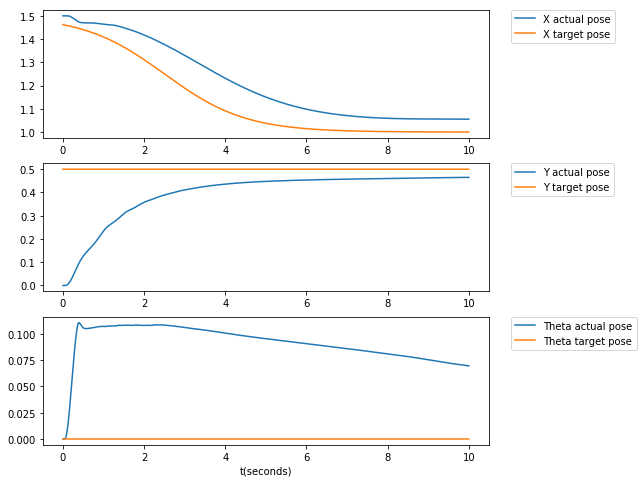

In [23]:
# This cell plots object pose tracking performance across time
# The object pose comes after the hand pose in the state
# vector, so extract it here.
object_pose_history = state_log.data()[num_hand_q:(num_hand_q+3), :]
ts = state_log.sample_times()
object_target_pose_history = np.vstack([
        controller.GetDesiredObjectPosition(t)
        for t in ts
    ]).T

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(8, 8)
plt.subplot(3, 1, 1)
plt.plot(ts, object_pose_history[0, :], label="X actual pose")
plt.plot(ts, object_target_pose_history[0, :], label="X target pose")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(3, 1, 2)
plt.plot(ts, object_pose_history[1, :], label="Y actual pose")
plt.plot(ts, object_target_pose_history[1, :], label="Y target pose")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(3, 1, 3)
plt.plot(ts, object_pose_history[2, :], label="Theta actual pose")
plt.plot(ts, object_target_pose_history[2, :], label="Theta target pose")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("t(seconds)");

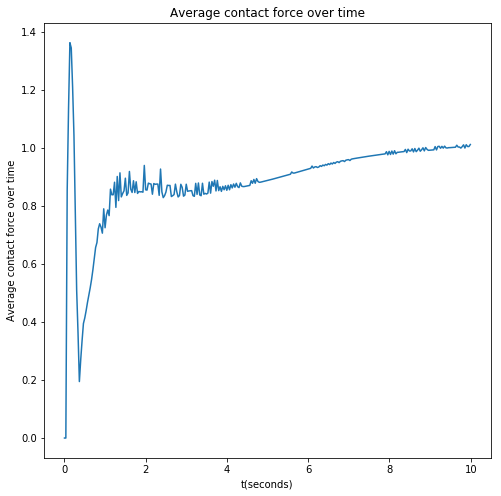

In [24]:
# Plot contact force tracking across time
# contact_log.data is a list (for every time point)
# of lists (for every contact at that time point)
# of tuples (id_1, id_2, r, f):
#  id_1 being the object ID of the first object in the contact pair
#  id_2 being the object ID of the first object in the contact pair
#  r being the contact location, in world frame
#  f being the contact force, in world frame
ts = contact_log.sample_times()
contact_results = contact_log.data()
average_cf_over_time = np.zeros(len(ts))
for i, cr in enumerate(contact_results):
    if len(cr) > 0:
        total_cf = 0.0
        for id_1, id_2, r, f in cr:
            total_cf += np.linalg.norm(f)
        total_cf /= len(cr)
        average_cf_over_time[i] = total_cf
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)
plt.plot(ts, average_cf_over_time)
plt.title("Average contact force over time")
plt.xlabel("t(seconds)")
plt.ylabel("Average contact force over time");

## Run Tests

In [25]:
import os
# Run the tests
os.popen("python test_set_5.py test_results.json")

# Print the results json for review
import test_set_5
print test_set_5.pretty_format_json_results("test_results.json")

Test Test force closure metric on some predefined grasps: 5.00/5.00.

Test Test force closure metric on some random grasps: 10.00/10.00.

Test Tests the convex hull volume is 0 for two points: 5.00/5.00.

Test Tests the convex hull volume is correctly computed on a small sample set: 5.00/5.00.

Test Test two finger grip of the box under motion A.: 0.00/10.00.
  * t:  0.0 t:  1.0015 t:  2.003 t:  3.0045 t:  4.006 t:  5.0075 t:  6.009
  * t:  7.0105 t:  8.012 t:  9.0135 Test Failed: The final pose error
  * was greater than 0.25 in at least one dimension: goal
  * [1.500000,0.499724,0.499724], target [1.583440,0.551335,0.154866].

Test Test four finger grip of the large ball under motion C.: 0.00/10.00.
  * Test Failed: shapes (15,4) and (2,) not aligned: 4 (dim 1) != 2 (dim
  * 0)

Test Test three finger grip of the triangle under motion B.: 0.00/10.00.
  * Test Failed: shapes (12,3) and (2,) not aligned: 3 (dim 1) != 2 (dim
  * 0)

TOTAL SCORE (automated tests only): 25.00/55.00

